In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc3 as pm


from ipywidgets import interact
import ipywidgets as ipyw

In [2]:
az.style.use('arviz-darkgrid')

In [3]:
%%HTML
<style>

.CodeMirror {
    width: 100vw;
}

.container {
    width: 99% !important;
}

.rendered_html {
  font-size:0.8em;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}


body {
  font-family: Ubuntu;
  background: #F0F0F0;
  background-color: #F0F0F0;
}


.reveal h1,
.reveal h2,
.reveal h3,
.reveal h4,
.reveal h5,
.reveal h6 {
  margin: 0 0 20px 0;
  color: #2a2eec;
  font-family: Ubuntu;
  line-height: 0.9em;
  letter-spacing: 0.02em;
  text-transform: none;
  text-shadow: none;
}

.reveal blockquote {
  display: block;
  position: relative;
  background: #fa7c17;
  border-radius: 15px;
  box-shadow: 0px 0px 2px rgba(0, 0, 0, 0.2);
  font-weight: bold;
}

</style>

In [4]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/osvaldo/anaconda3/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update("livereveal", {
              "theme": "serif",
              "transition": "zoom",
              "start_slideshow_at": "selected",
              "controls": "True",
              "progress": "False",
              "shortcut": "False"});

##### <center><img src="img/logo_inst.png" width="750">
<br>
<br>
<br>
<br>
<h1 align="center">Introducción a la programación probabilista</h1>    


<br>
<br>
<br>
<br>
<br>

## Objetivos

* Aprender a construir modelos simples con PyMC3 y a explorarlos con ArviZ
* Aprender sobre las pruebas predictivas a posteriori
* Comparar groupos en términos de tamaño del efecto (en oposición a la "significancia estadística")

# Programación probabilista

<br>


* Aunque conceptualmente simple, los modelos Bayesianos a menudo conducen a expresiones analíticamente intratables


* La *promesa de la programación probabilista* es la separación clara entre modelado e inferencia. Les practicantes deben centrarse en el modelado, no en *los detalles matemáticos / computacionales*


* Los modelos se escriben en código y luego se compilan para obtener la distribución *a posteriori*


* Los motores de inferencia universal pueden resolver cualquier modelo probabilista (!exagerado¡)

## PyMC3: Programación probabilista en Python
<br>

<center><img src="img/PyMC3_banner.svg" width=300></center>

* Construcción de modelos
    * Una gran colección de distribuciones de probabilidad
    * Una sintaxis simple y poderosa
    * Integración con herramientas del ecosistema Python

* Inferencia
    * Markov Chain Monte Carlo (NUTS, MH)
    * Monte Carlo Secuencial (SMC, SMC-ABC)
    * Inferencia Variacional


* backend computacional
    * Theano --> Velocidad, diferenciación automática, optimizaciones matemáticas
    * PyMC4 --> [Tensorflow Probability](https://medium.com/@pymc_devs/theano-tensorflow-and-the-future-of-pymc-6c9987bb19d5) más velocidad (vectorización), diferenciación automática, optimizaciones matemáticas, soporte para GPU y TPU.

In [5]:
np.random.seed(123)
n_experimentos = 4
theta_real = .35  # En casos reales este valor es desconocido
datos = stats.bernoulli.rvs(theta_real, size=n_experimentos)
datos

array([1, 0, 0, 0])

In [6]:
with pm.Model() as nuestro_primer_modelo:
    θ = pm.Beta('θ', alpha=1, beta=1)  # a priori
    y = pm.Bernoulli('y', p=θ, observed=datos)  # likelihood
    trace = pm.sample(1000)  # MCMC, motor de inferencia universal

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ]


## ArviZ: Análisis exploratorio de modelos Bayesianos

<br>
<br>
<center><img src="img/logo_arviz.png" width=400></center>
<br>

* Diagnosticar la calidad de la inferencia
* Criticar a los modelos, incluyendo la evaluación de los supuestos del modelo y de sus predicciones
* Comparación de modelos, incluyendo la selección y promediado de modelos
* Preparar los resultados para una audiencia particular

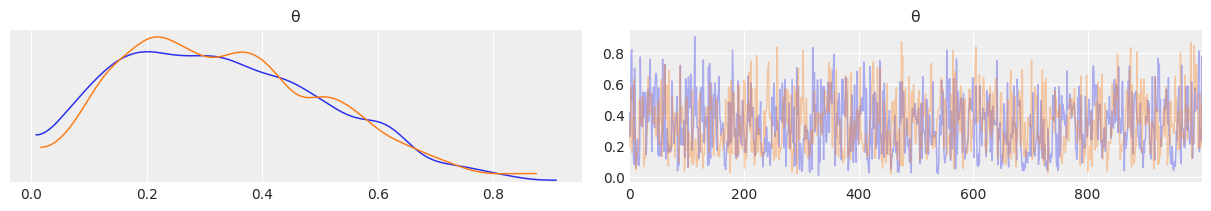

In [7]:
az.plot_trace(trace);

In [8]:
az.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
θ,0.338,0.177,0.027,0.637,0.006,0.004,809.0,809.0,792.0,1162.0,1.0


## El problema de los tanques alemanes

<br>

* Durante la segunda guerra mundial los aliados lograron recolectar números de series de tanques alemanes capturados

* Cómo estimar el número total de tanques alemanes a partir de esta información? 

In [9]:
serial_numbers = np.array([15, 20, 28])
with pm.Model() as model:
    N = pm.DiscreteUniform('N', lower=serial_numbers.max(), upper=serial_numbers.max()*10)
    #N = pm.Deterministic('N', pm.Exponential('N_', 1/10) + serial_numbers.max())
    #N = pm.Exponential('N', 1/10) + serial_numbers.max()
    y_obs = pm.DiscreteUniform('y_obs', lower=0, upper=N, observed=serial_numbers)

    trace = pm.sample(2000)

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [N]


The estimated number of effective samples is smaller than 200 for some parameters.


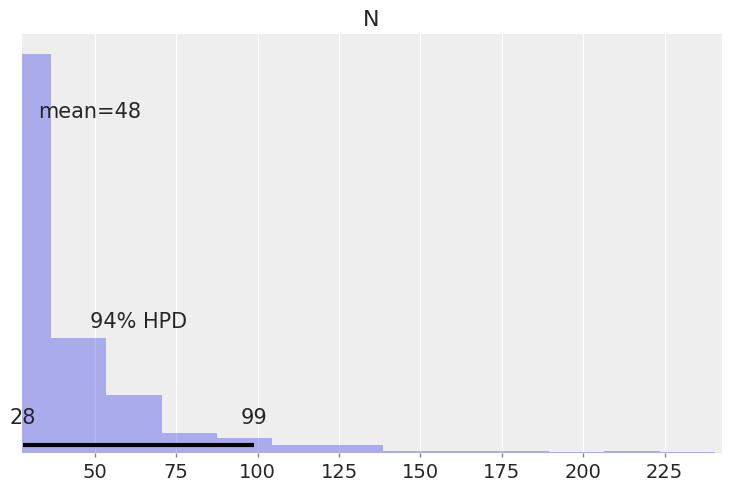

In [10]:
az.plot_posterior(trace, var_names='N');

## Modelos Multiparamétricos

<br>

Prácticamente todos los modelos de interés en estadística tienen más de un parámetro (multiparamétricos).

* Los parámetros que no son de inmediato interés pero son necesarios para definir un modelo de forma completa se llaman *nuisance parameters* (o parámetro estorbo). (Ej. La varianza cuando queremos estimar la media de una distribución Gaussiana).


* Al incorporar estos parámetros permitimos que la incertidumbre que tenemos sobre ellos se propague de forma adecuada a los resultados.

## Infiriendo la velocidad de la luz

A finales del siglo XIX Simon Newcomb realizó una serie de experimentos destinados a determinar la velocidad de la luz. En uno de ellos
Newcomb midió el tiempo que le tomó a la luz recorrer 7,442 métros. Las medidas obtenidas se muestran a continuación.

In [11]:
datos = np.array([24.828, 24.826, 24.833, 24.824, 24.834, 24.756, 24.827, 24.816,
                  24.84 , 24.798, 24.829, 24.822, 24.824, 24.821, 24.825, 24.83 ,
                  24.823, 24.829, 24.831, 24.819, 24.824, 24.82 , 24.836, 24.832,
                  24.836, 24.828, 24.825, 24.821, 24.828, 24.829, 24.837, 24.825,
                  24.828, 24.826, 24.83 , 24.832, 24.836, 24.826, 24.83 , 24.822,
                  24.836, 24.823, 24.827, 24.827, 24.828, 24.827, 24.831, 24.827,
                  24.826, 24.833, 24.826, 24.832, 24.832, 24.824, 24.839, 24.828,
                  24.824, 24.825, 24.832, 24.825, 24.829, 24.827, 24.828, 24.829,
                  24.816, 24.823])

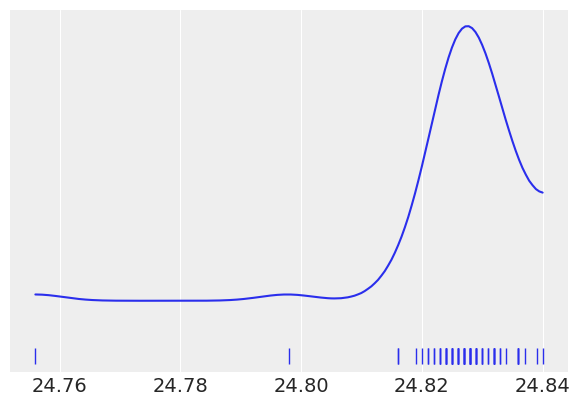

In [12]:
az.plot_kde(datos, rug=True)
plt.yticks([]);




\begin{align} 
\mu &\sim U(l, h) \\
\sigma &\sim \text{Half-Normal}(\sigma_{\sigma}) \\
y &\sim \mathcal{N}(\mu, \sigma)
\end{align}

In [13]:
with pm.Model() as modelo_g:
    # Priors
    μ = pm.Uniform('μ', 24, 25)
    #μ = pm.Normal('μ', 24, 10) # alternative prior
    σ = pm.HalfNormal('σ', sd=1)
    #σ = pm.HalfNormal('σ', sd=datos.std() * 100)
    # Likelihood
    y = pm.Normal('y', mu=μ, sd=σ, observed=datos)
    trace_g = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]


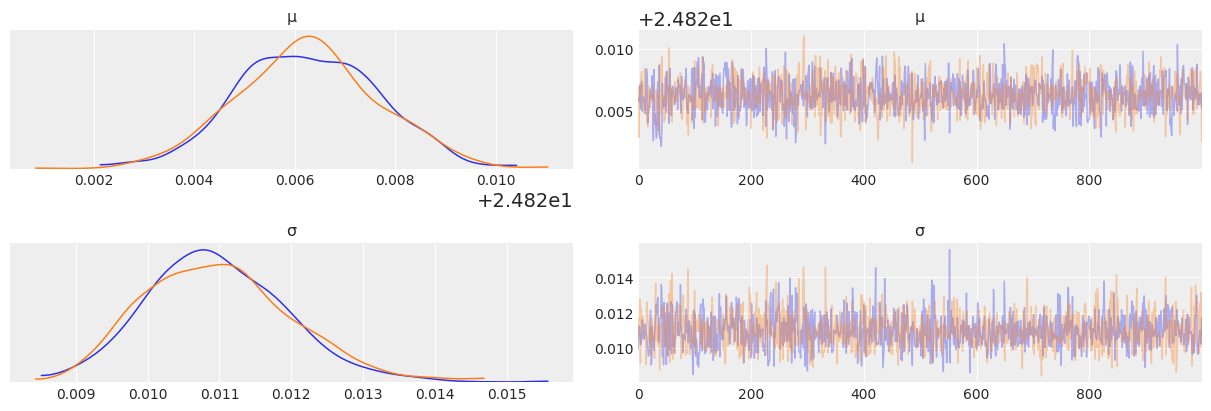

In [14]:
az.plot_trace(trace_g);

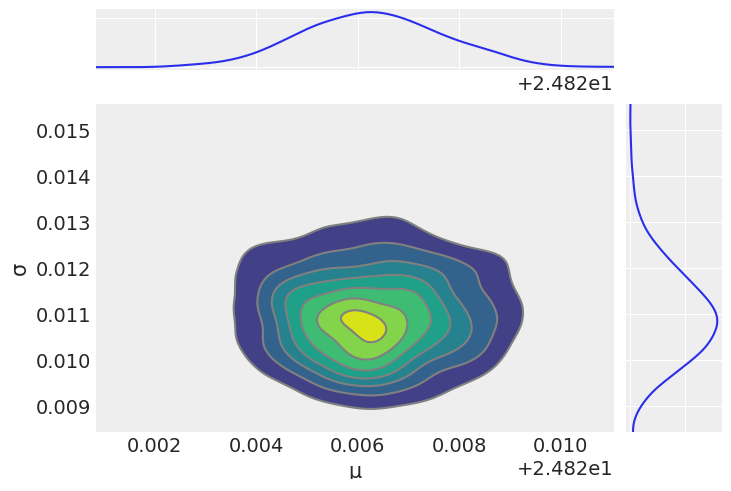

In [15]:
az.plot_joint(trace_g, kind='kde', fill_last=False);

## La distribución  a posteriori como único estimador


* La distribución a posteriori representa todo lo que sabemos sobre un problema (dado un modelo y un conjunto de datos).

* Como regla general las cantidades de interés se calculan como valores esperados:


$$
J = \int \varphi(\theta) \ \ p(\theta \mid y) d\theta
$$

* Por ejemplo, para calcular la media de $\theta$ reemplazamos $\varphi(\theta)$ con $\theta$:

$$
\bar \theta = \int \theta \ \ p(\theta \mid y) d\theta
$$

* Esto es un promedio ponderado, cada valor de $\theta$ es *pesado* de acuerdo al *posterior*.

* En la práctica y al usar métodos numéricos lo que tenemos son muestras (arrays) del posterior, por lo que estas integrales son solo sumas!

## Distribución predictiva a posteriori

Como ya vimos los modelos Bayesianos son generativos en el sentido que es posible generar datos a partir de ellos $\tilde{y}$:

\begin{equation}
p(\tilde{y} \,|\, y) = \int p(\tilde{y} \,|\, \theta) \, p(\theta \,|\, y) \, d\theta
\end{equation}


* $y$ --> datos observados
* $\theta$  --> parámetros

Usando PyMC3 obtener muestras es muy simple

In [16]:
pp_samples = pm.sample_posterior_predictive(trace_g, 100, modelo_g)

/home/osvaldo/proyectos/00_BM/pymc3/pymc3/sampling.py:1543: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


## Distribuciones predictivas a posteriori

* Los datos simulados pueden ser usado en si mismo como predicciones
* Los datos simulados pueden ser usados para evaluar las predicciones del modelo

arviz.data.io_pymc3 - WARNING - posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


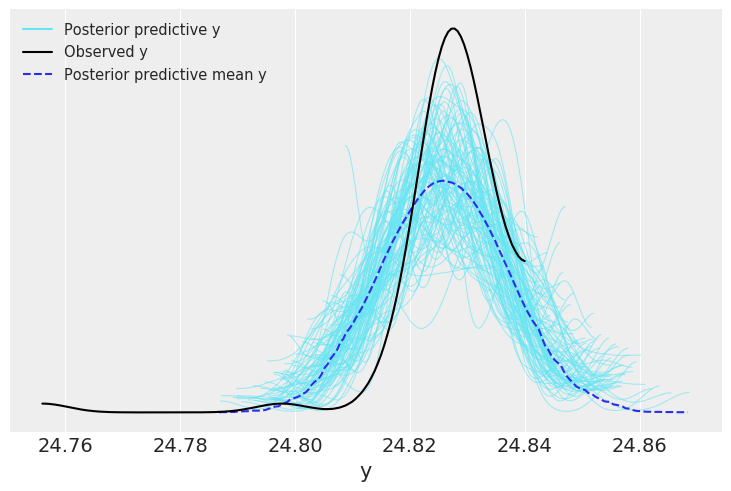

In [17]:
pp_data = az.from_pymc3(trace=trace_g, posterior_predictive=pp_samples)
az.plot_ppc(pp_data, alpha=0.6);

<center>
<img src="img/bayesian_workflow.png" width=700>
</center>

[Mathematical Theory of Bayesian Statistics](https://www.crcpress.com/Mathematical-Foundations-of-Bayesian-Statistics/Watanabe/p/book/9781482238068)

### Accidentes Mineros

<br>

* Tenemos registro del número de accidentes en minas de carbón en el Reino Unido entre 1851 y 1962 ([Jarrett, 1979](http://biomet.oxfordjournals.org/content/66/1/191.abstract)).


* Queremos estudiar el efecto de las regulaciones en seguridad sobre el número de accidentes. Además estamos interesados averiguar el año en que ocurrió un cambio en la tasa de los accidentes y los valores de ambas tasas.


* Para algunos años no tenemos datos
    * Los datos faltantes $\tilde{y}$ pueden ser estimados automáticamente usando la distribución predictiva a posteriori $\int p(\tilde{y} \,|\, \theta) \, p(\theta \,|\, y) \, d\theta$:

<br>
<br>

[Documentación de PyMC3](https://docs.pymc.io/notebooks/getting_started.html#Case-study-2:-Coal-mining-disasters)

In [18]:
accidentes = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                                  3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                                  2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                                  1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                                  0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                                  3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                                  0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)
años = np.arange(1851, 1962)

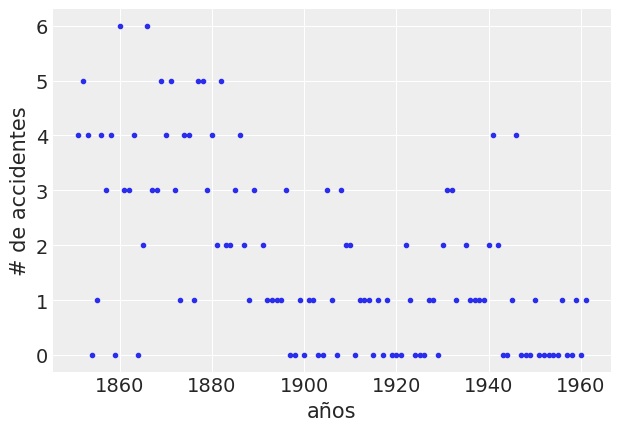

In [19]:
plt.plot(años, accidentes, '.')
plt.ylabel("# de accidentes")
plt.xlabel("años");

<img src="img/modelo_mineros.png" width=350>

\begin{equation}
y \sim Poisson(tasa)
\end{equation}

\begin{equation}
tasa = \begin{cases}
t_0, \text{if } t \ge cp,\\
t_1, \text{if } t \lt cp
\end{cases}
\end{equation}

\begin{align}
t_0 \sim Exp(\lambda) \\
t_1 \sim Exp(\lambda) \\
cp \sim U(L, H)
\end{align}


In [20]:
with pm.Model() as model_cat:

    pc = pm.DiscreteUniform('pc', lower=años.min(), upper=años.max())
    t_0 = pm.Exponential('t_0', 1/10)
    t_1 = pm.Exponential('t_1', 1/10)
    
    tasa = pm.math.switch(pc >= años, t_0, t_1)

    acc = pm.Poisson('acc', tasa, observed=accidentes)
    trace_cat = pm.sample(5000)

/home/osvaldo/proyectos/00_BM/pymc3/pymc3/model.py:1506: ImputationWarning: Data in acc contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [acc_missing]
>>Metropolis: [pc]
>NUTS: [t_1, t_0]


The number of effective samples is smaller than 10% for some parameters.


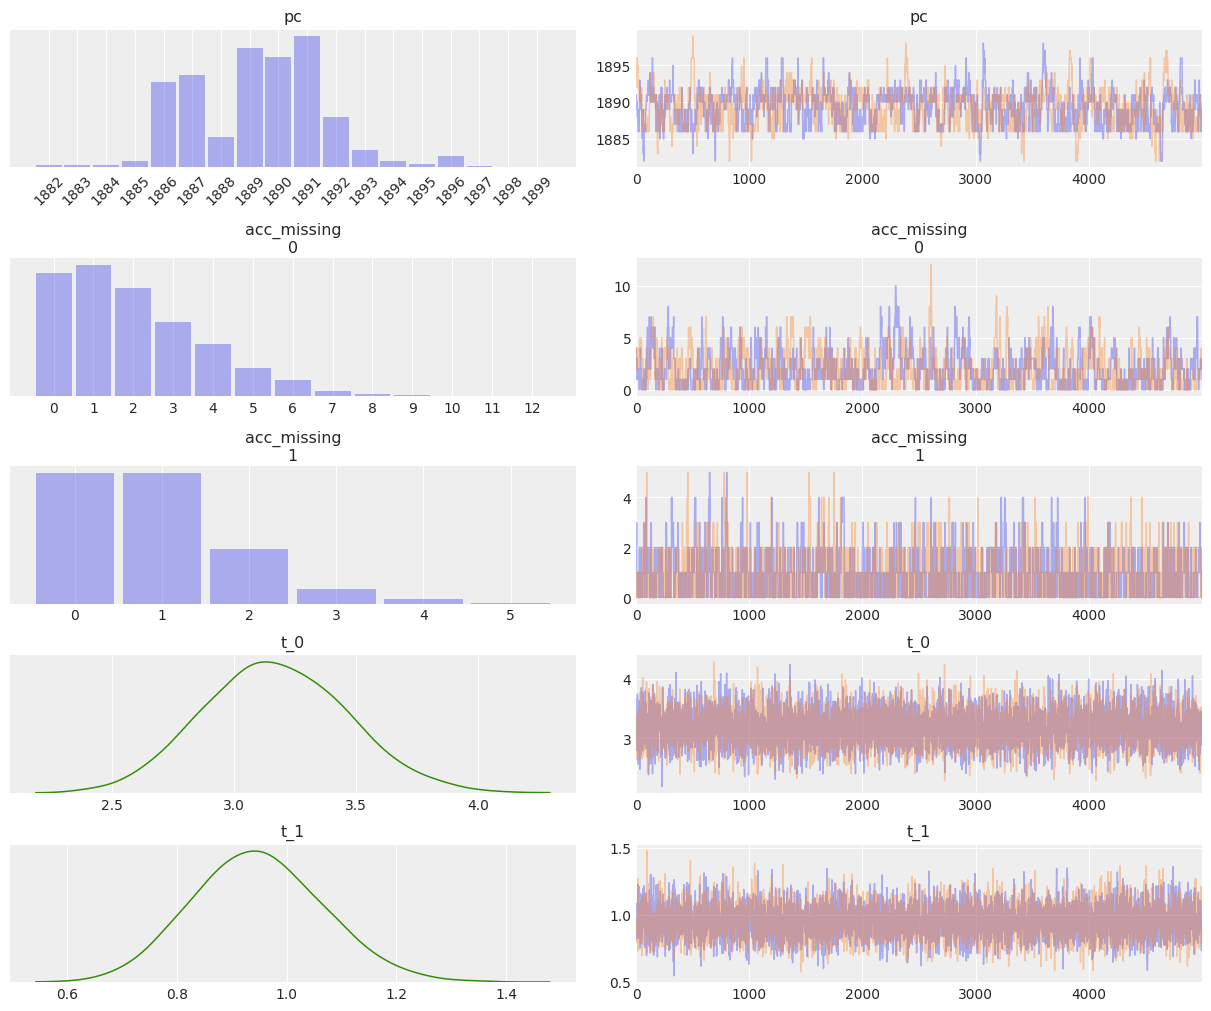

In [21]:
ax = az.plot_trace(trace_cat, combined=True);
[ticks.set_rotation(45) for ticks in ax[0, 0].get_xticklabels()];

In [22]:
az.summary(trace_cat)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
pc,1889.297,2.380,1886.00,1893.000,0.121,0.086,387.0,387.0,392.0,615.0,1.00
acc_missing[0],1.993,1.759,0.00,5.000,0.090,0.064,383.0,383.0,394.0,738.0,1.01
acc_missing[1],0.907,0.931,0.00,2.000,0.027,0.020,1220.0,1104.0,1275.0,1125.0,1.00
t_0,3.172,0.293,2.63,3.721,0.004,0.003,5253.0,5253.0,5203.0,5417.0,1.00
t_1,0.948,0.119,0.73,1.173,0.002,0.001,5298.0,5298.0,5272.0,6075.0,1.00


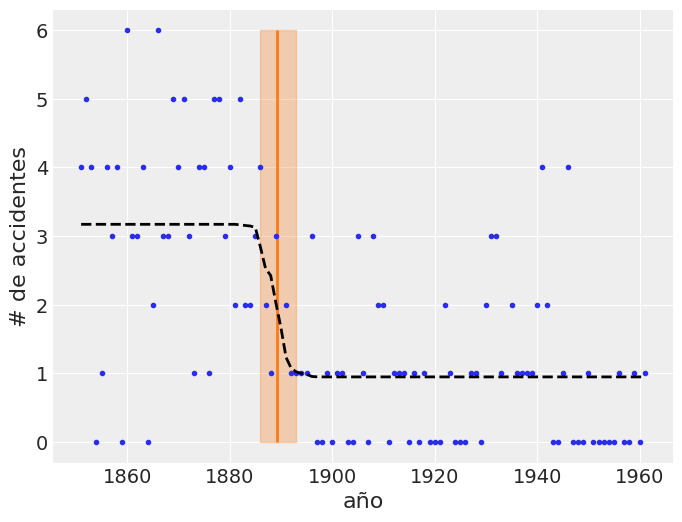

In [23]:
plt.figure(figsize=(8, 6))
plt.plot(años, accidentes, '.')
plt.ylabel("# de accidentes", fontsize=16)
plt.xlabel("año", fontsize=16)

plt.vlines(trace_cat['pc'].mean(), accidentes.min(), accidentes.max(), color='C1', lw=2)
accidentes_media = np.zeros_like(accidentes, dtype='float')
for i, año in enumerate(años):
    idx = año < trace_cat['pc']
    accidentes_media[i] = ((trace_cat['t_0'][idx].sum() + trace_cat['t_1'][~idx].sum()) 
                              / (len(trace_cat) * trace_cat.nchains))

pc_hpd = az.hpd(trace_cat['pc'])
plt.fill_betweenx([accidentes.min(), accidentes.max()], pc_hpd[0], pc_hpd[1], alpha=0.3, color='C1');
plt.plot(años, accidentes_media,  'k--', lw=2);

## Comparación de grupos

<br>


* Un problema muy común en inferencia estadística es la comparación de dos (o más) grupos


* Podemos estar interesados en saber si algún valor de un grupo es más grande que el del otro grupo


* Requerimos de un modelo estadístico porque los datos provienen de mediciones con errores que nos impiden sacar conclusiones simplemente calculando las diferencias a partir de los datos observados.

###  El conjunto de datos de las propinas 

* Queremos estudiar el efecto del día de la semana sobre el monto de propina en un restaurante determinado

[Bryant, P. G. and Smith, M](https://www.amazon.com/Practical-Data-Analysis-Peter-Bryant/dp/0256238715/ref=dp_ob_title_bk)

In [24]:
tips = pd.read_csv('../datos/propinas.csv')
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


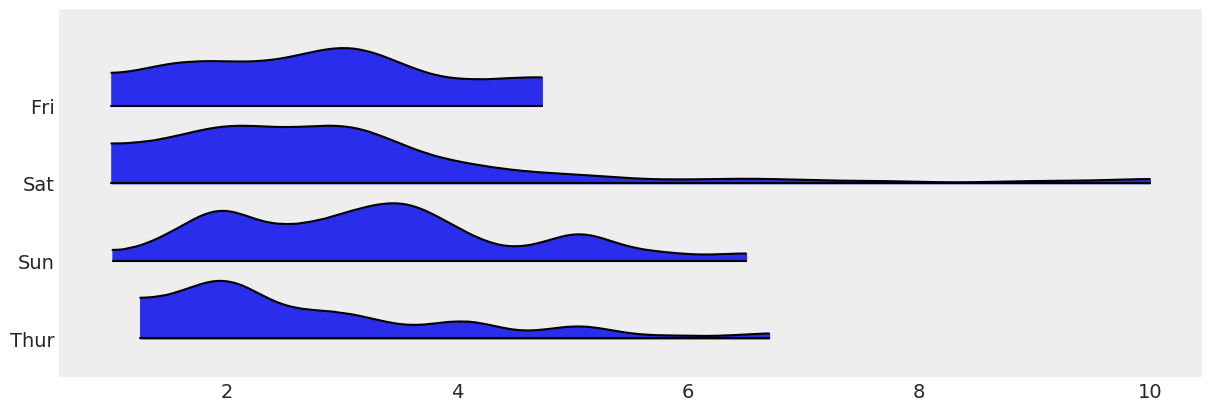

In [25]:
# Usamos arviz para graficar datos, no una distribución a posteriori ¯\_(ツ)_/¯
az.plot_forest(tips.pivot(columns='day', values='tip').to_dict('list'),
               kind='ridgeplot',
               figsize=(12, 4));

In [26]:
categorias = ['Thur', 'Fri', 'Sat', 'Sun']

tip = tips['tip'].values  # propina en dolares
idx = pd.Categorical(
    tips['day'],
    categories=categorias).codes  # ['Thur', 'Fri', 'Sat', 'Sun'] --> [0, 1, 2, 3]
grupos = len(np.unique(idx))

In [27]:
with pm.Model() as comparación_grupos:
    #  μ y σ son vectores con shape "groups"
    μ = pm.Normal('μ', mu=0, sd=10, shape=grupos)  
    σ = pm.HalfNormal('σ', sd=10, shape=grupos)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=tip)  # usamos idx para indexar μ y σ

    trace_cg = pm.sample(5000)
#az.plot_trace(trace_cg);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]


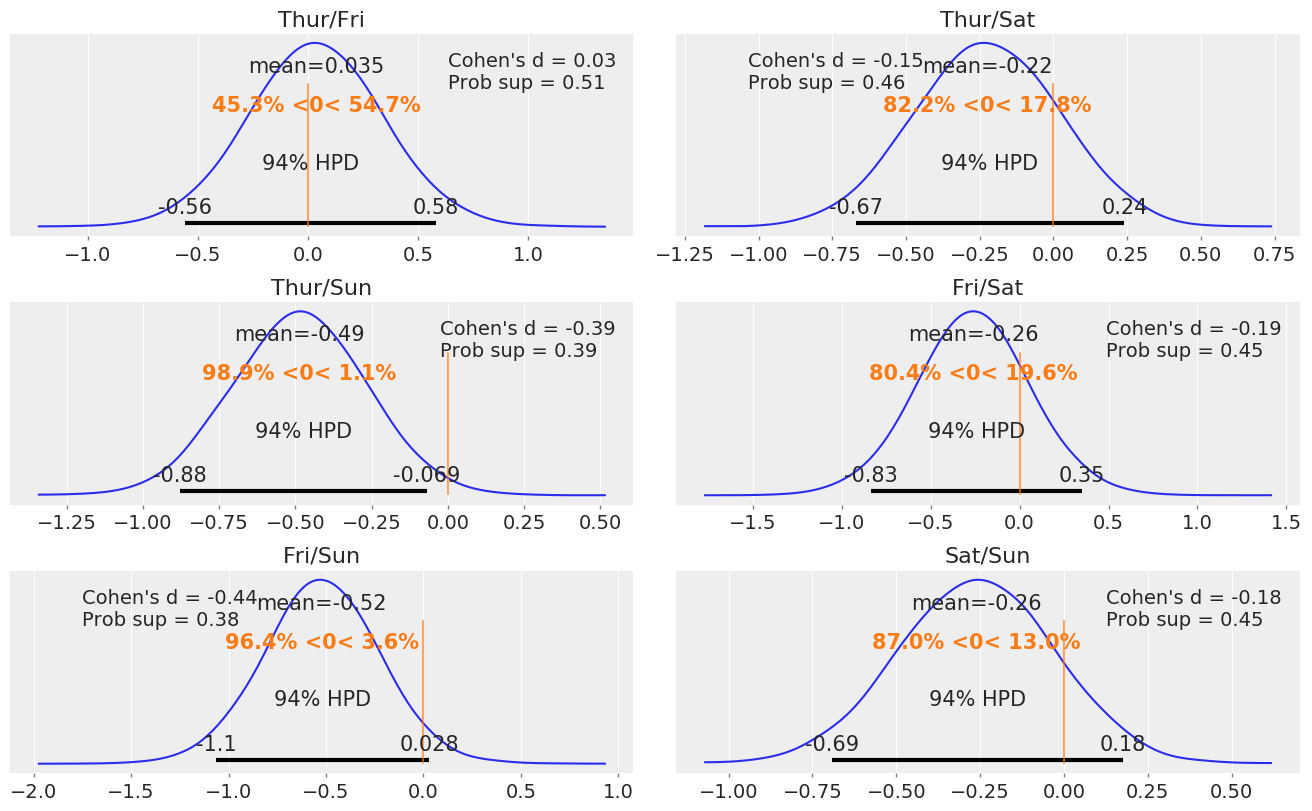

In [28]:
dist = stats.norm()

_, ax = plt.subplots(3, 2, figsize=(13, 8), constrained_layout=True)

comparisons = [(i,j) for i in range(4) for j in range(i+1, 4)]
pos = [(k,l) for k in range(3) for l in (0, 1)]

for (i, j), (k,l) in zip(comparisons, pos):
    means_diff = trace_cg['μ'][:,i] - trace_cg['μ'][:,j]
    d_cohen = (means_diff / ((trace_cg['σ'][:,i]**2 + trace_cg['σ'][:,j]**2) / 2)**0.5).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title("%s/%s" % (categorias[i], categorias[j]))
    ax[k, l].plot(0, label="Cohen's d = {:.2f}\nProb sup = {:.2f}".format(d_cohen, ps), alpha=0)
    ax[k,l ].legend()

### Tamaño del efecto


**Cohen's d**

$$
\frac{\mu_2 - \mu_1}{\sqrt{\frac{\sigma_1^2 + \sigma_2^2}{2}}}
$$


* Se puede interpretar como un *z-score*. Cuántas desviaciones estándar una media de un grupo está por encima (o por debajo) de la media del otro grupo
* [Ejemplo interactivo](http://rpsychologist.com/d3/cohend)

**Probabilidad de superioridad**

* La probabilidad que un dato tomado de un grupo sea mayor que la de un dato tomado del otro grupo.
* Si suponemos que los datos se distribuyen normalmente, entonces:


\begin{equation} \label{eq_ps}
ps = \Phi \left ( \frac{\delta}{\sqrt{2}} \right)
\end{equation}


$\Phi$ es la `cdf` de una distribución normal $\delta$ es el valor del Cohen's d.

## Ejercicios


1. Usar PyMC3 para reproducir el modelo beta-binomial mostrado en el notebook anterior (usando los 3 priors).


2. Reemplazar la distribución beta con una distribución uniforme en el intervalo [0,1]. ¿Cuán similar es el resultado comparado con el 
prior $beta(\alpha=1, \beta=1)$? Qué sucede al usar el intervalo [-1, 2]?

3. En la siguiente definición de un modelo probabilistico, indentificar el prior, el likelihood y el posterior:

$$y_i \sim Normal(\mu, \sigma)$$
$$\mu \sim Normal(0, 10)$$
$$\sigma \sim HalfNormal(25)$$

4. En el modelo anterior ¿Cuantas dimensiones tendrá el posterior? Comparar con el modelo de la moneda.

5. Correr el modelo de los tanques alemanes usando los siguientes priors, `N = pm.Deterministic('N', pm.Exponential('N_', 1/10) + serial_numbers.max())`, `N = pm.Exponential('N', 1/10) + serial_numbers.max()`. Cómo se ven afectados los resultados?

6. Modificá el `modelo_g` cambiando el prior para la media del likelihood gaussiano, probá usar la media empírica. Probá modificar la escala del prior para la desviación estándar ¿Cuán robusta es la inferencia a estos cambios? 

7. Cuán razonable es usar como likelihood una Gaussiana, que es un distribución *no acotada* (está definida de $-\infty$ to $\infty$), para modelar datos que si están acotados como los del ejemplo?

8. Ajustá los datos usados en el ejemplo de la velocidad de la luz usando un modelo similar al `modelo_g` pero usando como likelihood una distribución t de Student. Esta distribución tiene 3 parámetros: "mu", "sigma" y "nu", como prior de nu probá usar una distribución exponencial con media 30. Comparar los valores estimados para mu y sigma entre el `modelo_g` y este modelo. Qué se observa?

5. Discutir los resultados del ejemplo de las propinas

6. Aplica al menos uno de los modelos visto en este capítulo a datos propios o de tu interés.